In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv("heart_dataset_2.csv")

split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
for train_index, test_index in split_data.split(data, data['target']):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

#splitting for train set data
Ftrs_train = train_set.drop(columns='target', axis=1)
Trgt_train = train_set['target']

#splitting for test set data
Ftrs_test = test_set.drop(columns='target', axis=1)
Trgt_test = test_set['target']

##### BEST PERFORMING MODELS (Top 5):

``` 
Rank       Name                       Variable Name
----------------------------------------------------
1.    Gaussian Naive Bayes             model_gnb
2.    Support Vector Machine           model_svm
3.    MLP Neural Network               model_mlp 
4.    Random Forest                    model_rfc
5.    Logistic Regression              model_logreg
```

In [3]:
model_gnb=pickle.load(open('trained_gnb.sav', 'rb'))
model_svm=pickle.load(open('trained_svm.sav', 'rb'))
model_mlp=pickle.load(open('trained_mlp.sav', 'rb'))

### Confidence Scores for the models

In [4]:
cs_gnb=model_gnb.predict_proba(Ftrs_test)
cs_svm=model_svm.predict_proba(Ftrs_test)
cs_mlp=model_mlp.predict_proba(Ftrs_test)

### Applying Sugeno Fuzzy Integral based Ensemble Method

In [5]:
def find_max(arr):
    class_0=arr[0]
    class_1=arr[1]

    if class_0>class_1:
        return 0
    elif class_0<class_1:
        return 1
    else:
        return 1

In [6]:
from sympy.solvers import solve
from sympy import Symbol
def sugeno(solution,pred1,pred2,pred3, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) - (l+1), l )
    if len(lam) < 3:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,3):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

In [7]:
acc, ypred, cs_sugeno = sugeno([0.1,0.3,0.4], cs_gnb, cs_svm, cs_mlp, Trgt_test)

In [8]:
# s=1
# l=0
# v,m=0,0
# for x in range(1,21):
#     z=x/10
#     for i in range(1,21):
#         jj=i/10
#         for f in range(1,21):
#             k=f/10
#             try:
                
#                 acc, ypred,label= sugeno([z,jj,k],cs_gnb,cs_svm,cs_mlp,Trgt_test)
                
#                 if acc>0.8852459016393442:
#                     print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k)
#                     l=jj
#                     m=k
#                     v=z
#             except ValueError:
#                 pass
            
                
# print("done")
# print(v,l,m)

In [9]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy Score:  0.8852459016393442
ROC-AUC Score:  0.8804112554112554
PR-AUC Score:  0.9166459678754761


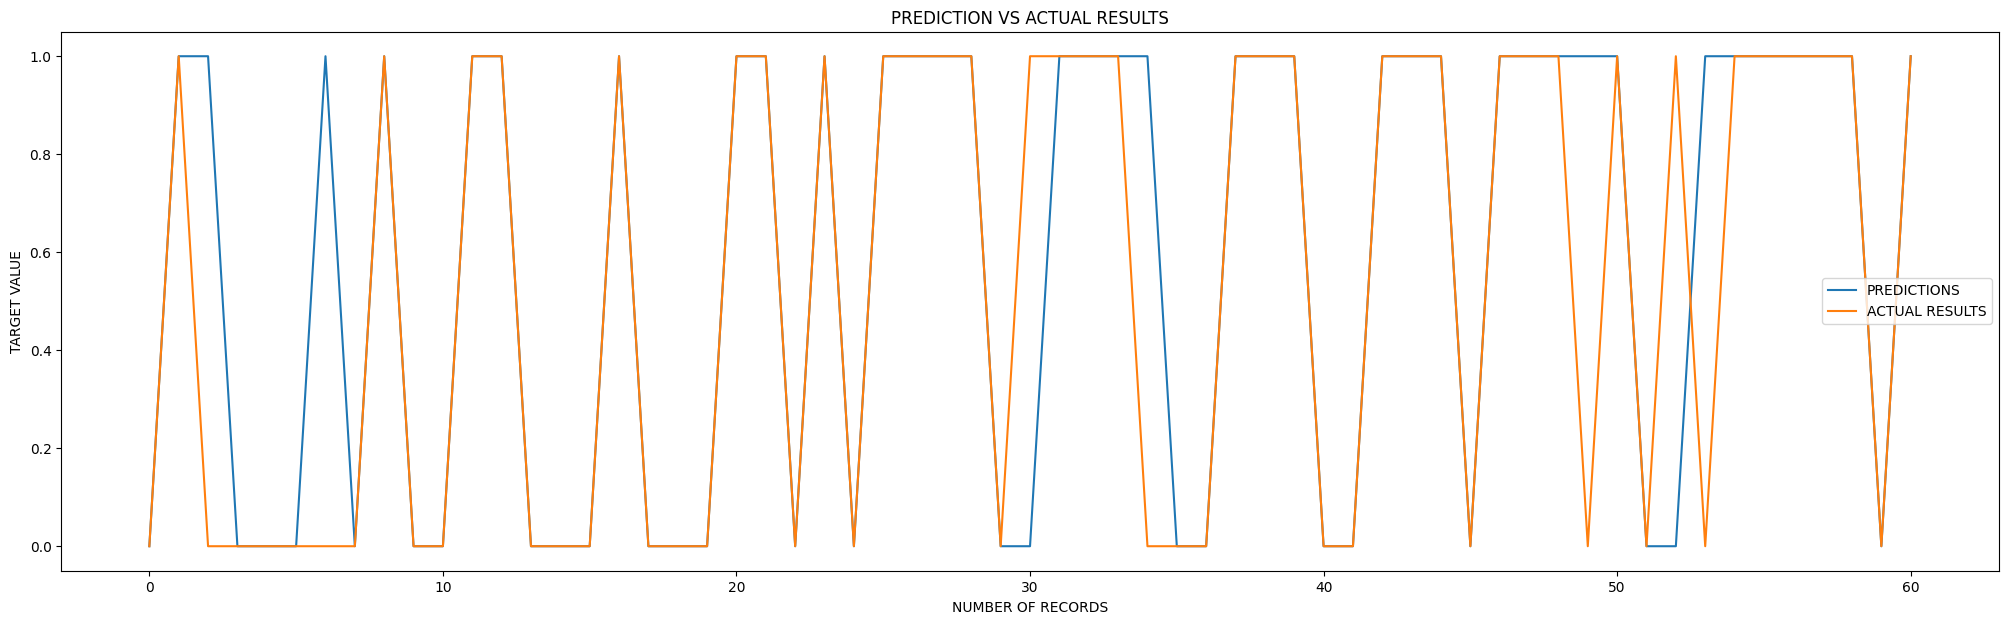

In [10]:
fig = plt.figure(figsize=(25, 7))
plt.plot(ypred,label="PREDICTIONS")
plt.xlabel("NUMBER OF RECORDS")
plt.ylabel("TARGET VALUE")
test_result=np.array(Trgt_test)
plt.plot(test_result,label="ACTUAL RESULTS")
plt.title("PREDICTION VS ACTUAL RESULTS")
plt.legend()